Esta libreta contiene el problema de suavizado de imágenes. Contiene varias funcionalidades:

- Adición de ruidos *gaussiano* y *salt and pepper* a la imagen.
- Suavizado de la imagen usando una implementación propia del algoritmo *Iterated Conditional Modes (ICM)*.

# Paquetes a importar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
import cv2 

%matplotlib inline
%load_ext memory_profiler

# Adición de ruido

In [2]:
def add_noise(image, noise_type, var=10, freq=0.01):
    noisy = image.copy()
    
    if noise_type == "gaussian":
        gauss = np.random.normal(0, var**0.5, image.shape)
        noisy = noisy + gauss
    
    elif noise_type == "saltAndPepper":
        s_vs_p = 0.5
        
        # Salt mode
        num_salt = np.ceil(freq * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        noisy[coords] = 255

        # Pepper mode
        num_pepper = np.ceil(freq* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        noisy[coords] = 0
    
    elif noise_type == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
    
    elif noise_type =="speckle":
        gauss = np.random.randn(image.shape)
        gauss = gauss.reshape(image.shape)        
        noisy = image + image * gauss

    np.clip(noisy, 0, 255, out=noisy)             #### Eliminar valores por debajo de 0 o encima de 255
    
    return noisy.astype(int)

In [3]:
def add_gaussian_noise(image, var):
    noise = np.random.normal(0, np.sqrt(var), image.shape)
    noisy_image = image + noise
    
    np.clip(noisy_image, 0, 255, out=noisy_image)
    
    return noisy_image.astype(int)

# ICM (Iterated Conditional Modes)

Definimos el potencial de un pixel como la suma de dos potenciales:
   
- El primero que penaliza los valores muy diferentes a sus vecinos, que no es más que la suma de las distancias euclideas al cuadrado con cada uno de sus vecinos.
- El segundo, multiplicado por el factor $\lambda$, que penaliza los valores muy distantes al píxel de la imagen original.

In [4]:
def conditional_energy_of_pixel(pixel_i, neighbours, ground_pixel, lamb):
    energy = 0
    
    for pixel_j in neighbours:
        energy += (pixel_i - pixel_j)**2
        
    energy += lamb * (pixel_i - ground_pixel)**2
    
    return energy

Definimos el algoritmo en sí.

In [5]:
def ICM(initial_image, lamb=1, max_steps=10):
    image = initial_image.copy()
    n_rows = len(image)
    n_cols = len(image[0])
    rows = range(n_rows)
    columns = range(n_cols)
    
    neighbours_changed = np.zeros(initial_image.shape)
        
    for n in range(max_steps):
        print('Iteración ', n)
        last_image = image.copy()
        
        for i in range(n_rows):
            for j in range(n_cols):
                current_pixel = image[i][j]
                ground_pixel = initial_image[i][j]

                neighbours = []
    
                if i == 0:
                    neighbours.append(image[i+1][j])
                elif i == n_rows-1:
                    neighbours.append(image[i-1][j])
                else:
                    neighbours.append(image[i-1][j])
                    neighbours.append(image[i+1][j])
                    
                if j == 0:
                    neighbours.append(image[i][j+1])
                elif j == n_cols-1:
                    neighbours.append(image[i][j-1])
                else:
                    neighbours.append(image[i][j-1])
                    neighbours.append(image[i][j+1])

                energies = np.array([conditional_energy_of_pixel(p, neighbours, ground_pixel, lamb) \
                                            for p in range(256)])
                new_pixel = np.argmin(energies)
                                
                image[i][j] = new_pixel
                
        dist = np.linalg.norm(image - last_image)
        
#         if dist < 100:
#             return image
        
        print('Distancia entre imagenes (norma 2): ', dist)
        print('Distancia a la imagen original (norma 2): ', np.linalg.norm(image - initial_image))
        
    return image

# Aplicación del algoritmo con una imagen de prueba

Primeramente cargamos la imagen en blanco y negro y le añadimos los distintos tipos de ruido. 

C:\Users\usuario\.conda\envs\pgm\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
C:\Users\usuario\.conda\envs\pgm\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


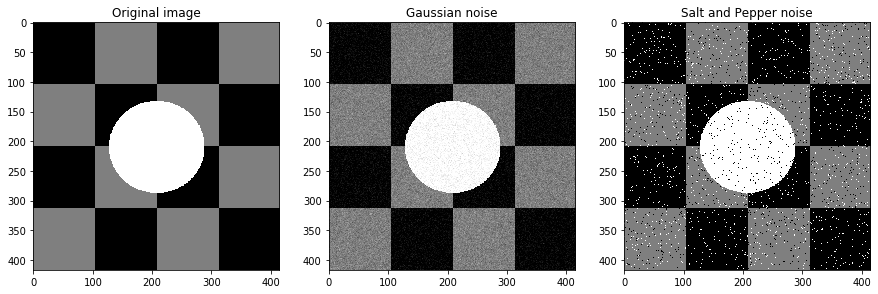

In [6]:
image_0 = cv2.imread('data/image_smoothing/test_ball.bmp', 0)
gaussian_noisy_image = add_noise(image_0, 'gaussian', var=200)
salt_and_pepper_noisy_image = add_noise(image_0, 'saltAndPepper', freq=0.05)

fig, ax = plt.subplots(1, 3, figsize=(15,15))

ax[0].set_title('Original image')
ax[0].imshow(image_0, cmap='gray')
ax[1].set_title('Gaussian noise')
ax[1].imshow(gaussian_noisy_image, cmap='gray')
ax[2].set_title('Salt and Pepper noise')
ax[2].imshow(salt_and_pepper_noisy_image, cmap='gray')

plt.show()

### Aplicamos ICM a la imagen con ruido gaussiano añadido para distintos valores de $\lambda$ .

In [298]:
%time new_image_0 = ICM(gaussian_noisy_image, lamb=2, max_steps=3)

Iteración  0
Distancia entre imagenes (norma 2):  3721.8974999319903
Iteración  1
Distancia entre imagenes (norma 2):  817.1407467505215
Iteración  2
Distancia entre imagenes (norma 2):  276.4995479200644
Wall time: 11min 55s


In [299]:
%time new_image_1 = ICM(gaussian_noisy_image, lamb=1, max_steps=3)

Iteración  0
Distancia entre imagenes (norma 2):  4425.34021291019
Iteración  1
Distancia entre imagenes (norma 2):  1158.927952894398
Iteración  2
Distancia entre imagenes (norma 2):  443.8828674323892
Wall time: 8min 44s


In [300]:
%time new_image_2 = ICM(gaussian_noisy_image, lamb=0.5, max_steps=3)

Iteración  0
Distancia entre imagenes (norma 2):  4891.752446720909
Iteración  1
Distancia entre imagenes (norma 2):  1434.6584959494717
Iteración  2
Distancia entre imagenes (norma 2):  622.4612437734578
Wall time: 19min 27s


### Visualizamos los resultados.

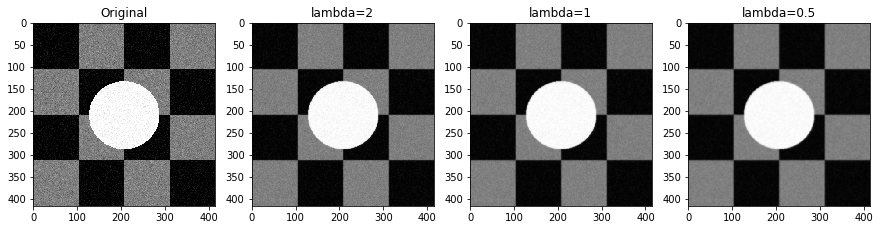

In [310]:
fig, ax = plt.subplots(1, 4, figsize=(15,15))

ax[0].set_title('Original')
ax[0].imshow(gaussian_noisy_image, cmap='gray')
ax[1].set_title('lambda=2')
ax[1].imshow(new_image_0, cmap='gray')
ax[2].set_title('lambda=1')
ax[2].imshow(new_image_1, cmap='gray')
ax[3].set_title('lambda=0.5')
ax[3].imshow(new_image_2, cmap='gray')

plt.show()

### Aplicamos el algoritmo a la imagen con ruido salt and pepper y distintos valores de $\lambda$

In [302]:
%time new_image_sp_0 = ICM(salt_and_pepper_noisy_image, lamb=2, max_steps=3)

Iteración  0
Distancia entre imagenes (norma 2):  9812.951492797669
Iteración  1
Distancia entre imagenes (norma 2):  2040.2004803450077
Iteración  2
Distancia entre imagenes (norma 2):  541.4314361024857
Wall time: 8min 30s


In [303]:
%time new_image_sp_1 = ICM(salt_and_pepper_noisy_image, lamb=1, max_steps=3)

Iteración  0
Distancia entre imagenes (norma 2):  11570.984054954013
Iteración  1
Distancia entre imagenes (norma 2):  2838.5653066293894
Iteración  2
Distancia entre imagenes (norma 2):  897.6218580226308
Wall time: 8min 30s


In [304]:
%time new_image_sp_2 = ICM(salt_and_pepper_noisy_image, lamb=0.5, max_steps=3)

Iteración  0
Distancia entre imagenes (norma 2):  12700.49471477391
Iteración  1
Distancia entre imagenes (norma 2):  3435.941210207183
Iteración  2
Distancia entre imagenes (norma 2):  1232.9947282936776
Wall time: 19min 21s


### Visualizamos los resultados

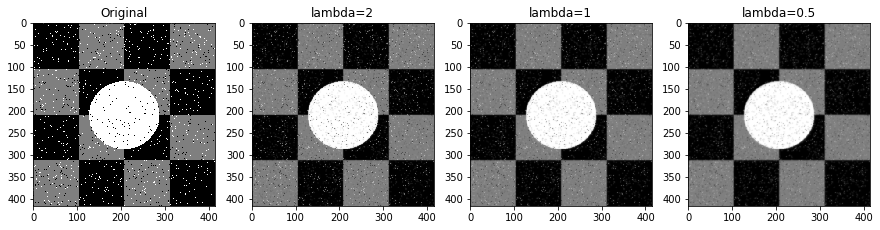

In [311]:
fig, ax = plt.subplots(1, 4, figsize=(15,15))

ax[0].set_title('Original')
ax[0].imshow(salt_and_pepper_noisy_image, cmap='gray')
ax[1].set_title('lambda=2')
ax[1].imshow(new_image_sp_0, cmap='gray')
ax[2].set_title('lambda=1')
ax[2].imshow(new_image_sp_1, cmap='gray')
ax[3].set_title('lambda=0.5')
ax[3].imshow(new_image_sp_2, cmap='gray')

plt.show()

# Lenna

Repetimos el mismo proceso para la imagen *Lenna*.

C:\Users\usuario\.conda\envs\pgm\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
C:\Users\usuario\.conda\envs\pgm\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


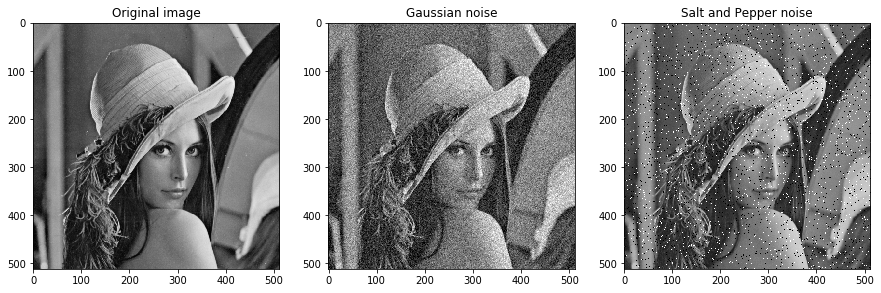

In [7]:
lenna_bgr = cv2.imread('data/image_smoothing/lenna.png', 1)
lenna_original = cv2.cvtColor(lenna_bgr, cv2.COLOR_BGR2RGB)
# lenna_gray = np.dot(image_0[...,:3], [0.299, 0.587, 0.114])
lenna_gray = cv2.cvtColor(lenna_original, cv2.COLOR_BGR2GRAY)
lenna_gray_gaussian_noisy = add_noise(lenna_gray, 'gaussian', var=500)
lenna_gray_salt_and_pepper_noisy = add_noise(lenna_gray, 'saltAndPepper', freq=0.05)

fig, ax = plt.subplots(1, 3, figsize=(15,15))

ax[0].set_title('Original image')
ax[0].imshow(lenna_gray, cmap='gray')
ax[1].set_title('Gaussian noise')
ax[1].imshow(lenna_gray_gaussian_noisy, cmap='gray')
ax[2].set_title('Salt and Pepper noise')
ax[2].imshow(lenna_gray_salt_and_pepper_noisy, cmap='gray')

plt.show()

In [8]:
%time lenna_new_image_gaussian_0 = ICM(lenna_gray_gaussian_noisy, lamb=2, max_steps=3)

Iteración  0
Distancia entre imagenes (norma 2):  7801.004550697301
Distancia a la imagen original (norma 2):  7801.004550697301
Iteración  1
Distancia entre imagenes (norma 2):  1661.5965214214912
Distancia a la imagen original (norma 2):  7634.927439078907
Iteración  2
Distancia entre imagenes (norma 2):  485.72317218761555
Distancia a la imagen original (norma 2):  7624.193465541126
Wall time: 14min 53s


In [9]:
%time lenna_new_image_gaussian_1 = ICM(lenna_gray_gaussian_noisy, lamb=1, max_steps=3)

Iteración  0
Distancia entre imagenes (norma 2):  9201.380983308973
Distancia a la imagen original (norma 2):  9201.380983308973
Iteración  1
Distancia entre imagenes (norma 2):  2308.0171143212956
Distancia a la imagen original (norma 2):  9164.268492356605
Iteración  2
Distancia entre imagenes (norma 2):  781.5055981885223
Distancia a la imagen original (norma 2):  9203.701972576035
Wall time: 14min 50s


In [10]:
%time lenna_new_image_gaussian_2 = ICM(lenna_gray_gaussian_noisy, lamb=0.5, max_steps=3)

Iteración  0
Distancia entre imagenes (norma 2):  10112.949174202351
Distancia a la imagen original (norma 2):  10112.949174202351
Iteración  1
Distancia entre imagenes (norma 2):  2800.5851174352833
Distancia a la imagen original (norma 2):  10226.38636078258
Iteración  2
Distancia entre imagenes (norma 2):  1065.2901013339042
Distancia a la imagen original (norma 2):  10349.990772942747
Wall time: 33min 56s


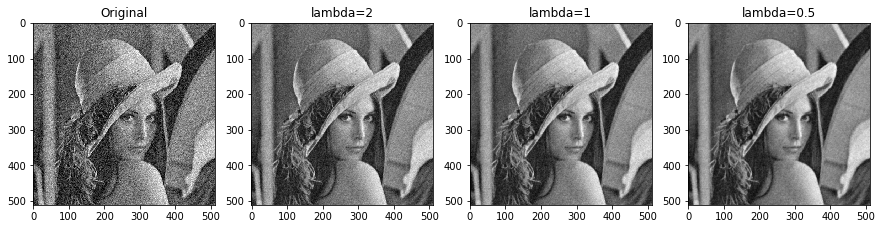

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(15,15))

ax[0].set_title('Original')
ax[0].imshow(lenna_gray_gaussian_noisy, cmap='gray')
ax[1].set_title('lambda=2')
ax[1].imshow(lenna_new_image_gaussian_0, cmap='gray')
ax[2].set_title('lambda=1')
ax[2].imshow(lenna_new_image_gaussian_1, cmap='gray')
ax[3].set_title('lambda=0.5')
ax[3].imshow(lenna_new_image_gaussian_2, cmap='gray')

plt.show()

In [12]:
%time lenna_new_image_sp_0 = ICM(lenna_gray_salt_and_pepper_noisy, lamb=2, max_steps=3)

Iteración  0
Distancia entre imagenes (norma 2):  10372.80285168864
Distancia a la imagen original (norma 2):  10372.80285168864
Iteración  1
Distancia entre imagenes (norma 2):  2175.6302535127606
Distancia a la imagen original (norma 2):  10087.737803888442
Iteración  2
Distancia entre imagenes (norma 2):  596.5844449866255
Distancia a la imagen original (norma 2):  10060.238416657927
Wall time: 14min 31s


In [13]:
%time lenna_new_image_sp_1 = ICM(lenna_gray_salt_and_pepper_noisy, lamb=1, max_steps=3)

Iteración  0
Distancia entre imagenes (norma 2):  12221.632337785326
Distancia a la imagen original (norma 2):  12221.632337785326
Iteración  1
Distancia entre imagenes (norma 2):  3011.9482067260055
Distancia a la imagen original (norma 2):  12070.229368160324
Iteración  2
Distancia entre imagenes (norma 2):  974.6927721082167
Distancia a la imagen original (norma 2):  12085.380879393086
Wall time: 13min 53s


In [14]:
%time lenna_new_image_sp_2 = ICM(lenna_gray_salt_and_pepper_noisy, lamb=0.5, max_steps=3)

Iteración  0
Distancia entre imagenes (norma 2):  13423.82940892799
Distancia a la imagen original (norma 2):  13423.82940892799
Iteración  1
Distancia entre imagenes (norma 2):  3639.9026085872133
Distancia a la imagen original (norma 2):  13435.927098641165
Iteración  2
Distancia entre imagenes (norma 2):  1323.521439191674
Distancia a la imagen original (norma 2):  13531.505016072677
Wall time: 30min 18s


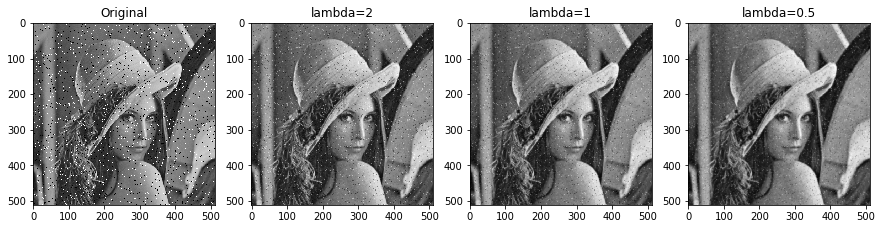

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(15,15))

ax[0].set_title('Original')
ax[0].imshow(lenna_gray_salt_and_pepper_noisy, cmap='gray')
ax[1].set_title('lambda=2')
ax[1].imshow(lenna_new_image_sp_0, cmap='gray')
ax[2].set_title('lambda=1')
ax[2].imshow(lenna_new_image_sp_1, cmap='gray')
ax[3].set_title('lambda=0.5')
ax[3].imshow(lenna_new_image_sp_2, cmap='gray')

plt.show()